In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:0000:01


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Define GNN Models
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

# Dataset and DataLoader
from torch_geometric.datasets import UPFD

root = "./data/UPFD"
dataset_name = "gossipcop"
dataset = UPFD(root=root, name=dataset_name, feature="bert", split="train")

# Feature Normalization
all_features = torch.cat([data.x for data in dataset], dim=0)
scaler = StandardScaler()
scaler.fit(all_features.cpu())

for data in dataset:
    data.x = torch.tensor(scaler.transform(data.x.cpu()), dtype=torch.float32)

# Split dataset into training and testing
train_dataset = dataset[: int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)) :]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Models
in_channels = 768
hidden_channels = 128
num_classes = 2

gcn_model = GCNModel(in_channels, hidden_channels, num_classes).to(device)
gat_model = GATModel(in_channels, hidden_channels, num_classes).to(device)
graphsage_model = GraphSAGEModel(in_channels, hidden_channels, num_classes).to(device)
attention_fusion = AttentionFusion(num_views=3, embedding_dim=hidden_channels).to(device)

models = [gcn_model, gat_model, graphsage_model]
optimizer = torch.optim.Adam(
    list(gcn_model.parameters()) +
    list(gat_model.parameters()) +
    list(graphsage_model.parameters()) +
    list(attention_fusion.parameters()),
    lr=0.005
)
criterion = torch.nn.CrossEntropyLoss()

# Training Function
def train_combined(models, fusion_module, loader, optimizer, criterion):
    for model in models:
        model.train()
    fusion_module.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Extract embeddings from all models
        embeddings = [
            model(data.x, data.edge_index, data.batch) for model in models
        ]
        
        # Fuse embeddings
        fused_output = fusion_module(embeddings)
        
        # Compute loss
        loss = criterion(fused_output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation Function
def evaluate_combined(models, fusion_module, loader):
    for model in models:
        model.eval()
    fusion_module.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            
            # Extract embeddings and fuse them
            embeddings = [
                model(data.x, data.edge_index, data.batch) for model in models
            ]
            fused_output = fusion_module(embeddings)
            
            # Predictions and probabilities
            probs = F.softmax(fused_output, dim=1)
            preds = fused_output.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs[:, 1].cpu())
            all_labels.append(data.y.cpu())
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    return all_preds.numpy(), all_probs.numpy(), all_labels.numpy()

# Training Loop
epochs = 50
for epoch in range(1, epochs + 1):
    train_loss = train_combined(models, attention_fusion, train_loader, optimizer, criterion)
    print(f"Epoch {epoch}/{epochs}, Loss: {train_loss:.4f}")

# Evaluate
preds, probs, labels = evaluate_combined(models, attention_fusion, test_loader)

# Metrics
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
accuracy = accuracy_score(labels, preds)
roc_auc = roc_auc_score(labels, probs)
pr_auc = average_precision_score(labels, probs)

# Print Results
print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.5939
Epoch 2/50, Loss: 0.3729
Epoch 3/50, Loss: 0.3087
Epoch 4/50, Loss: 0.2592
Epoch 5/50, Loss: 0.1892
Epoch 6/50, Loss: 0.1685
Epoch 7/50, Loss: 0.1431
Epoch 8/50, Loss: 0.1464
Epoch 9/50, Loss: 0.1111
Epoch 10/50, Loss: 0.0912
Epoch 11/50, Loss: 0.1135
Epoch 12/50, Loss: 0.0765
Epoch 13/50, Loss: 0.0588
Epoch 14/50, Loss: 0.0498
Epoch 15/50, Loss: 0.0654
Epoch 16/50, Loss: 0.0268
Epoch 17/50, Loss: 0.0424
Epoch 18/50, Loss: 0.0759
Epoch 19/50, Loss: 0.0606
Epoch 20/50, Loss: 0.0993
Epoch 21/50, Loss: 0.0465
Epoch 22/50, Loss: 0.0940
Epoch 23/50, Loss: 0.0786
Epoch 24/50, Loss: 0.0305
Epoch 25/50, Loss: 0.0105
Epoch 26/50, Loss: 0.0061
Epoch 27/50, Loss: 0.0041
Epoch 28/50, Loss: 0.0018
Epoch 29/50, Loss: 0.0014
Epoch 30/50, Loss: 0.0010
Epoch 31/50, Loss: 0.0009
Epoch 32/50, Loss: 0.0008
Epoch 33/50, Loss: 0.0006
Epoch 34/50, Loss: 0.0005
Epoch 35/50, Loss: 0.0004
Epoch 36/50, Loss: 0.0004
Epoch 37/50, Loss: 0.0003
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Define GNN Models
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

# Dataset and DataLoader
from torch_geometric.datasets import UPFD

root = "./data/UPFD"
dataset_name = "gossipcop"
dataset = UPFD(root=root, name=dataset_name, feature="bert", split="train")

# Feature Normalization
all_features = torch.cat([data.x for data in dataset], dim=0)
scaler = StandardScaler()
scaler.fit(all_features.cpu())

for data in dataset:
    data.x = torch.tensor(scaler.transform(data.x.cpu()), dtype=torch.float32)

# Split dataset into training and testing
train_dataset = dataset[: int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)) :]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Models
in_channels = 768
hidden_channels = 128
num_classes = 2

# Training Function
def train_combined(models, fusion_module, loader, optimizer, criterion):
    for model in models:
        model.train()
    fusion_module.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Extract embeddings from all models
        embeddings = [
            model(data.x, data.edge_index, data.batch) for model in models
        ]
        
        # Fuse embeddings
        fused_output = fusion_module(embeddings)
        
        # Compute loss
        loss = criterion(fused_output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation Function
def evaluate_combined(models, fusion_module, loader):
    for model in models:
        model.eval()
    fusion_module.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            
            # Extract embeddings and fuse them
            embeddings = [
                model(data.x, data.edge_index, data.batch) for model in models
            ]
            fused_output = fusion_module(embeddings)
            
            # Predictions and probabilities
            probs = F.softmax(fused_output, dim=1)
            preds = fused_output.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs[:, 1].cpu())
            all_labels.append(data.y.cpu())
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    return all_preds.numpy(), all_probs.numpy(), all_labels.numpy()

# Function to run a single experiment
def run_experiment(models, fusion_module, train_loader, test_loader, optimizer, criterion, epochs=50):
    for epoch in range(1, epochs + 1):
        train_combined(models, fusion_module, train_loader, optimizer, criterion)
    
    preds, probs, labels = evaluate_combined(models, fusion_module, test_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs)
    pr_auc = average_precision_score(labels, probs)
    return precision, recall, f1, accuracy, roc_auc, pr_auc

# Multiple runs
num_runs = 10
results = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Reinitialize models and optimizer for each run
    gcn_model = GCNModel(in_channels, hidden_channels, num_classes).to(device)
    gat_model = GATModel(in_channels, hidden_channels, num_classes).to(device)
    graphsage_model = GraphSAGEModel(in_channels, hidden_channels, num_classes).to(device)
    attention_fusion = AttentionFusion(num_views=3, embedding_dim=hidden_channels).to(device)
    models = [gcn_model, gat_model, graphsage_model]
    
    optimizer = torch.optim.Adam(
        list(gcn_model.parameters()) +
        list(gat_model.parameters()) +
        list(graphsage_model.parameters()) +
        list(attention_fusion.parameters()),
        lr=0.005
    )
    
    # Run the experiment
    metrics = run_experiment(models, attention_fusion, train_loader, test_loader, optimizer, torch.nn.CrossEntropyLoss())
    results.append(metrics)

# Compute statistics
results = np.array(results)
metrics_mean = results.mean(axis=0)
metrics_std = results.std(axis=0)

# Print results
metrics_names = ["Precision", "Recall", "F1 Score", "Accuracy", "ROC-AUC", "PR-AUC"]
print("\nPerformance ov  er 10 runs:")
for name, mean, std in zip(metrics_names, metrics_mean, metrics_std):
    print(f"{name}: {mean:.4f} ± {std:.4f}")


Extracting data/UPFD/gossipcop/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Performance over 10 runs:
Precision: 0.9116 ± 0.0204
Recall: 0.9515 ± 0.0081
F1 Score: 0.9310 ± 0.0117
Accuracy: 0.9374 ± 0.0112
ROC-AUC: 0.9760 ± 0.0057
PR-AUC: 0.9732 ± 0.0095


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00a 0:00:01


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Define GNN Models
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_embeddings = global_mean_pool(x, batch)
        return self.fc(graph_embeddings)

# Dataset and DataLoader
from torch_geometric.datasets import UPFD

root = "./data/UPFD"
dataset_name = "gossipcop"
dataset = UPFD(root=root, name=dataset_name, feature="bert", split="train")

# Feature Normalization
all_features = torch.cat([data.x for data in dataset], dim=0)
scaler = StandardScaler()
scaler.fit(all_features.cpu())

for data in dataset:
    data.x = torch.tensor(scaler.transform(data.x.cpu()), dtype=torch.float32)

# Split dataset into training and testing
train_dataset = dataset[: int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)) :]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Models
in_channels = 768
hidden_channels = 128
num_classes = 2

# Training Function
def train_combined(models, fusion_module, loader, optimizer, criterion):
    for model in models:
        model.train()
    fusion_module.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Extract embeddings from all models
        embeddings = [
            model(data.x, data.edge_index, data.batch) for model in models
        ]
        
        # Fuse embeddings
        fused_output = fusion_module(embeddings)
        
        # Compute loss
        loss = criterion(fused_output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation Function
def evaluate_combined(models, fusion_module, loader):
    for model in models:
        model.eval()
    fusion_module.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            
            # Extract embeddings and fuse them
            embeddings = [
                model(data.x, data.edge_index, data.batch) for model in models
            ]
            fused_output = fusion_module(embeddings)
            
            # Predictions and probabilities
            probs = F.softmax(fused_output, dim=1)
            preds = fused_output.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs[:, 1].cpu())
            all_labels.append(data.y.cpu())
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    return all_preds.numpy(), all_probs.numpy(), all_labels.numpy()

# Function to run a single experiment
def run_experiment(models, fusion_module, train_loader, test_loader, optimizer, criterion, epochs=50):
    for epoch in range(1, epochs + 1):
        train_combined(models, fusion_module, train_loader, optimizer, criterion)
    
    preds, probs, labels = evaluate_combined(models, fusion_module, test_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs)
    pr_auc = average_precision_score(labels, probs)
    return precision, recall, f1, accuracy, roc_auc, pr_auc

# Multiple runs
num_runs = 10
results = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Reinitialize models and optimizer for each run
    gcn_model = GCNModel(in_channels, hidden_channels, num_classes).to(device)
    gat_model = GATModel(in_channels, hidden_channels, num_classes).to(device)
    graphsage_model = GraphSAGEModel(in_channels, hidden_channels, num_classes).to(device)
    attention_fusion = AttentionFusion(num_views=3, embedding_dim=hidden_channels).to(device)
    models = [gcn_model, gat_model, graphsage_model]
    
    optimizer = torch.optim.Adam(
        list(gcn_model.parameters()) +
        list(gat_model.parameters()) +
        list(graphsage_model.parameters()) +
        list(attention_fusion.parameters()),
        lr=0.005
    )
    
    # Run the experiment
    metrics = run_experiment(models, attention_fusion, train_loader, test_loader, optimizer, torch.nn.CrossEntropyLoss())
    results.append(metrics)

# Compute statistics
results = np.array(results)
metrics_mean = results.mean(axis=0)
metrics_std = results.std(axis=0)

# Print results
metrics_names = ["Precision", "Recall", "F1 Score", "Accuracy", "ROC-AUC", "PR-AUC"]
print("\nPerformance over 10 runs:")
for name, mean, std in zip(metrics_names, metrics_mean, metrics_std):
    print(f"{name}: {mean:.4f} ± {std:.4f}")


Extracting data/UPFD/gossipcop/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Performance over 10 runs:
Precision: 0.9156 ± 0.0242
Recall: 0.9433 ± 0.0148
F1 Score: 0.9290 ± 0.0147
Accuracy: 0.9361 ± 0.0135
ROC-AUC: 0.9759 ± 0.0047
PR-AUC: 0.9735 ± 0.0088


Original proposed after finetuning for cheking

Epoch 1/50: Loss: 0.3043, Accuracy: 0.5659, Precision: 0.5428, Recall: 0.9929, F1: 0.7019, ROC-AUC: 0.9828, PR-AUC: 0.9868
Epoch 2/50: Loss: 0.1371, Accuracy: 0.8462, Precision: 0.7759, Recall: 0.9858, F1: 0.8683, ROC-AUC: 0.9846, PR-AUC: 0.9890
Epoch 3/50: Loss: 0.1176, Accuracy: 0.9359, Precision: 0.9073, Recall: 0.9751, F1: 0.9400, ROC-AUC: 0.9841, PR-AUC: 0.9886
Epoch 4/50: Loss: 0.0919, Accuracy: 0.8974, Precision: 0.8419, Recall: 0.9858, F1: 0.9082, ROC-AUC: 0.9826, PR-AUC: 0.9861
Epoch 5/50: Loss: 0.0912, Accuracy: 0.9341, Precision: 0.8964, Recall: 0.9858, F1: 0.9390, ROC-AUC: 0.9824, PR-AUC: 0.9857
Epoch 6/50: Loss: 0.0811, Accuracy: 0.8956, Precision: 0.9786, Recall: 0.8149, F1: 0.8893, ROC-AUC: 0.9815, PR-AUC: 0.9818
Epoch 7/50: Loss: 0.0709, Accuracy: 0.9158, Precision: 0.8660, Recall: 0.9893, F1: 0.9236, ROC-AUC: 0.9818, PR-AUC: 0.9846
Epoch 8/50: Loss: 0.0537, Accuracy: 0.9487, Precision: 0.9317, Recall: 0.9715, F1: 0.9512, ROC-AUC: 0.9812, PR-AUC: 0.9825
Epoch 9/50: Loss

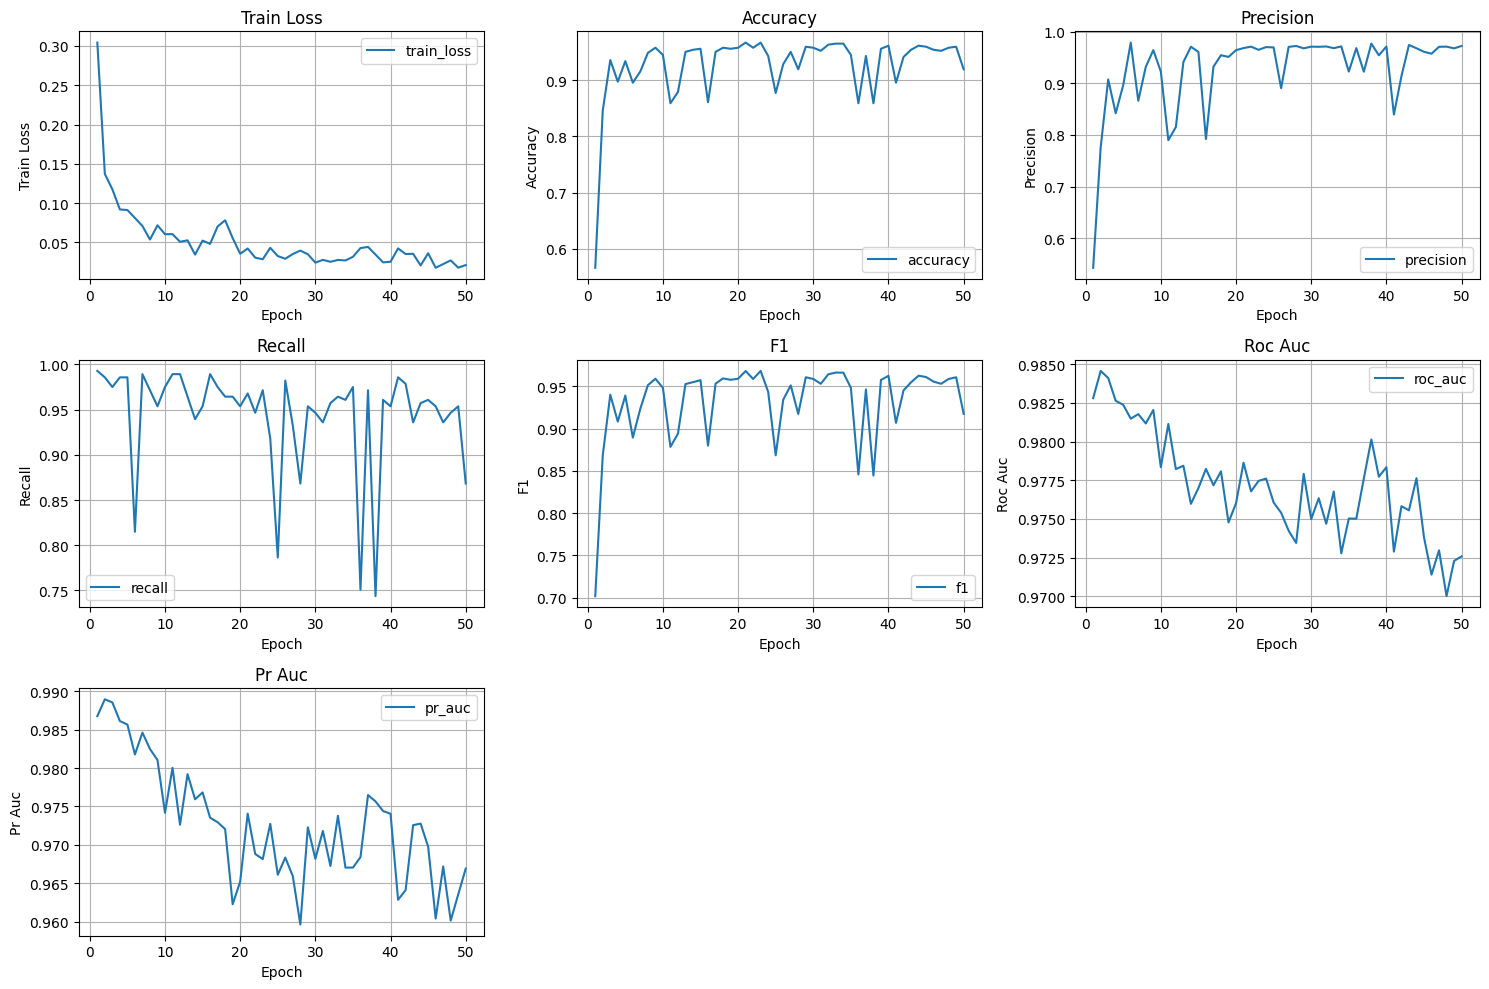

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced GNN models with Dropout and Batch Normalization
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

# Enhanced Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Load Dataset
dataset_name = 'gossipcop'
feature = 'content'
root = './data/UPFD'

train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Models
in_channels = train_dataset.num_features
hidden_channels = 128
out_channels = 64

models = {
    'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}
attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

# Optimizers and Scheduler
optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.001) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.001)
scheduler_attn = CosineAnnealingLR(optimizer_attn, T_max=50)

# Training epoch
def train_epoch(models, attention_fusion, loader, optimizers, optimizer_attn):
    for model in models.values():
        model.train()
    attention_fusion.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        for optimizer in optimizers.values():
            optimizer.zero_grad()
        optimizer_attn.zero_grad()

        embeddings = [model(data.x, data.edge_index, data.batch) for model in models.values()]
        fused_output = attention_fusion(embeddings)
        loss = F.cross_entropy(fused_output, data.y)
        loss.backward()

        for optimizer in optimizers.values():
            optimizer.step()
        optimizer_attn.step()

        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluate metrics
def evaluate_metrics(models, attention_fusion, loader):
    for model in models.values():
        model.eval()
    attention_fusion.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index, data.batch) for model in models.values()]
            fused_output = attention_fusion(embeddings)

            probs = F.softmax(fused_output, dim=1)
            preds = probs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_probs.append(probs[:, 1].cpu())
            all_labels.append(data.y.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=0)
    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    pr_auc = average_precision_score(all_labels, all_probs)

    return accuracy, precision, recall, f1, roc_auc, pr_auc

# Train the model
def train_with_metrics(models, attention_fusion, loaders, optimizers, optimizer_attn, scheduler_attn, epochs):
    train_loader, val_loader = loaders
    results = []

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(models, attention_fusion, train_loader, optimizers, optimizer_attn)
        accuracy, precision, recall, f1, roc_auc, pr_auc = evaluate_metrics(models, attention_fusion, val_loader)

        scheduler_attn.step()

        results.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
        })

        print(f"Epoch {epoch}/{epochs}: "
              f"Loss: {train_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1: {f1:.4f}, "
              f"ROC-AUC: {roc_auc:.4f}, "
              f"PR-AUC: {pr_auc:.4f}")

    return results

# Plot metrics
def plot_detailed_metrics(results):
    epochs = [result["epoch"] for result in results]
    metrics = ["train_loss", "accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 3, i)
        values = [result[metric] for result in results]
        plt.plot(epochs, values, label=metric)
        plt.title(metric.replace("_", " ").title())
        plt.xlabel("Epoch")
        plt.ylabel(metric.replace("_", " ").title())
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run training and plot metrics
epochs = 50
results = train_with_metrics(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, scheduler_attn, epochs)
plot_detailed_metrics(results)


In [7]:
1+2

3

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50: Loss=0.2059, Accuracy=0.5458, Precision=0.5561, Recall=0.7755, F1=0.6477
Epoch 2/50: Loss=0.1380, Accuracy=0.5604, Precision=0.5659, Recall=0.7891, F1=0.6591
Epoch 3/50: Loss=0.1040, Accuracy=0.5641, Precision=0.5686, Recall=0.7891, F1=0.6610
Epoch 4/50: Loss=0.1061, Accuracy=0.5604, Precision=0.5659, Recall=0.7891, F1=0.6591
Epoch 5/50: Loss=0.0800, Accuracy=0.5971, Precision=0.5902, Recall=0.8231, F1=0.6875
Epoch 6/50: Loss=0.0896, Accuracy=0.5971, Precision=0.5902, Recall=0.8231, F1=0.6875
Epoch 7/50: Loss=0.1113, Accuracy=0.5531, Precision=0.5610, Recall=0.7823, F1=0.6534
Epoch 8/50: Loss=0.0806, Accuracy=0.6337, Precision=0.6146, Recall=0.8571, F1=0.7159
Epoch 9/50: Loss=0.0767, Accuracy=0.5678, Precision=0.5707, Recall=0.7959, F1=0.6648
Epoch 10/50: Loss=0.0565, Accuracy=0.6007, Precision=0.5931, Recall=0.8231, F1=0.6895
Epoch 11/50: Loss=0.0850, Accuracy=0.6117, Precision=0.6000, Recall=0.8367, F1=0.6989
Epoch 12/50: Loss=0.0589, Accuracy=0.6117, Precision=0.6000, Re

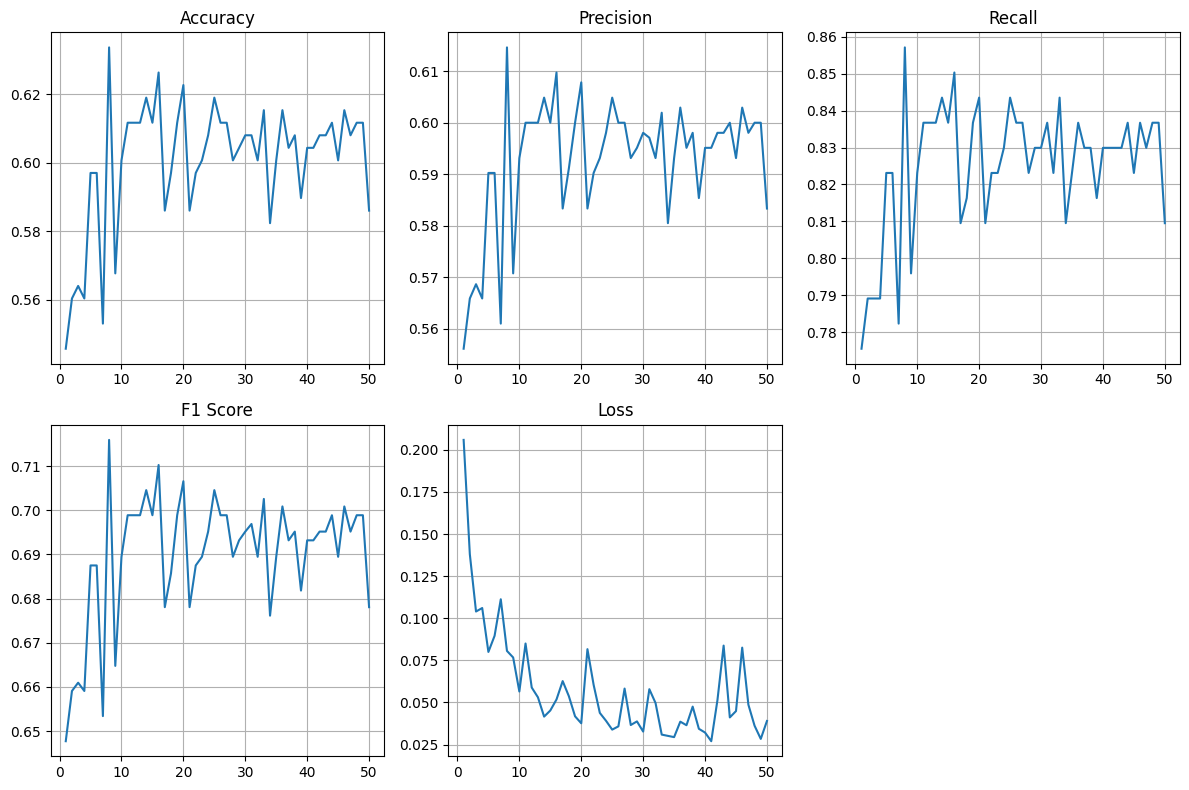

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (e.g., GossipCop)
dataset_name = 'gossipcop'
feature = 'content'
root = './data/UPFD'

train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define improved GNN Models with Dropout and Batch Normalization
class ImprovedGCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(ImprovedGCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

class ImprovedGATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(ImprovedGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

class ImprovedGraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(ImprovedGraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.fc = torch.nn.Linear(out_channels, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        return self.fc(x)

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    'GCN': ImprovedGCNModel(in_channels, hidden_channels, out_channels).to(device),
    'GAT': ImprovedGATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': ImprovedGraphSAGEModel(in_channels, hidden_channels, out_channels).to(device)
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.005, weight_decay=1e-5) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = StepLR(optimizer_attn, step_size=10, gamma=0.7)

# Training
def train_epoch(models, attention_fusion, loader, optimizers, optimizer_attn):
    for model in models.values():
        model.train()
    attention_fusion.train()
    total_loss = 0

    for data in loader:
        data = data.to(device)
        for optimizer in optimizers.values():
            optimizer.zero_grad()
        optimizer_attn.zero_grad()

        embeddings = [model(data.x, data.edge_index, data.batch) for model in models.values()]
        fused_embedding = attention_fusion(embeddings)
        loss = F.cross_entropy(fused_embedding, data.y)
        loss.backward()

        for optimizer in optimizers.values():
            optimizer.step()
        optimizer_attn.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Extract embeddings
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index, data.batch) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.cpu())
            all_labels.append(data.y.cpu())
    all_embeddings = torch.cat(all_embeddings).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_embeddings, all_labels

# Compute metrics using SVM
def compute_metrics(embeddings, labels):
    # Normalize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings)

    # Train-test split
    split_idx = len(labels) // 2
    train_embeddings, test_embeddings = embeddings[:split_idx], embeddings[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]

    # Train One-Class SVM
    svm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.75)
    svm_labels = svm.fit_predict(test_embeddings)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average="binary", pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

# Training loop with metrics
def train_with_metrics(models, attention_fusion, loaders, optimizers, optimizer_attn, scheduler, epochs=50):
    train_loader, val_loader = loaders
    results = []

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(models, attention_fusion, train_loader, optimizers, optimizer_attn)

        # Extract embeddings and compute metrics
        embeddings, labels = get_embeddings(models, attention_fusion, val_loader)
        metrics = compute_metrics(embeddings, labels)

        scheduler.step()
        results.append({"epoch": epoch, "loss": train_loss, **metrics})

        print(f"Epoch {epoch}/{epochs}: Loss={train_loss:.4f}, "
              f"Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, "
              f"Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")

    return results

# Train the model
results = train_with_metrics(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, scheduler)

# Plot results
def plot_metrics(results):
    epochs = [r["epoch"] for r in results]
    accuracy = [r["accuracy"] for r in results]
    precision = [r["precision"] for r in results]
    recall = [r["recall"] for r in results]
    f1 = [r["f1"] for r in results]
    loss = [r["loss"] for r in results]

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, accuracy, label="Accuracy")
    plt.title("Accuracy")
    plt.grid()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, precision, label="Precision")
    plt.title("Precision")
    plt.grid()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, recall, label="Recall")
    plt.title("Recall")
    plt.grid()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, f1, label="F1 Score")
    plt.title("F1 Score")
    plt.grid()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, loss, label="Loss")
    plt.title("Loss")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_metrics(results)


In [14]:

import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (Politifact)
dataset_name = 'gossipcop'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE)
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    #'GCN': GCNModel(in_channels, hidden_channels, out_channels).to(device),
    #'GAT': GATModel(in_channels, hidden_channels, out_channels).to(device),
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.005) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

# Train the models
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=20):
    train_loader, val_loader = loaders
    for epoch in range(1, epochs + 1):
        for data in train_loader:
            data = data.to(device)
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            loss = F.mse_loss(fused_embedding, fused_embedding)  # Simplified dummy loss
            loss.backward()

            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for i in range(10):
    # Train the models
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=10)

    # Get test embeddings
    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    # Standardize embeddings
    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    # Apply One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.95)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    # Evaluate results
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

# Calculate average values and standard deviation
avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}
std_results = {key: np.std([r[key] for r in results]) for key in results[0]}

# Display results for each run
for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

# Display average results with standard deviation
print("\n--- Average Results with ± Standard Deviation ---")
for key in avg_results:
    print(f"{key}: {avg_results[key]:.4f} ± {std_results[key]:.4f}")




/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Run 1: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 2: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 3: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 4: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 5: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 6: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 7: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 8: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accuracy': 0.9458333333333333}
Run 9: {'precision': 1.0, 'recall': 0.9458333333333333, 'f1': 0.9721627408993576, 'accur

In [10]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
print("Hi")

Hi


Generating projections for embeddings before fusion...


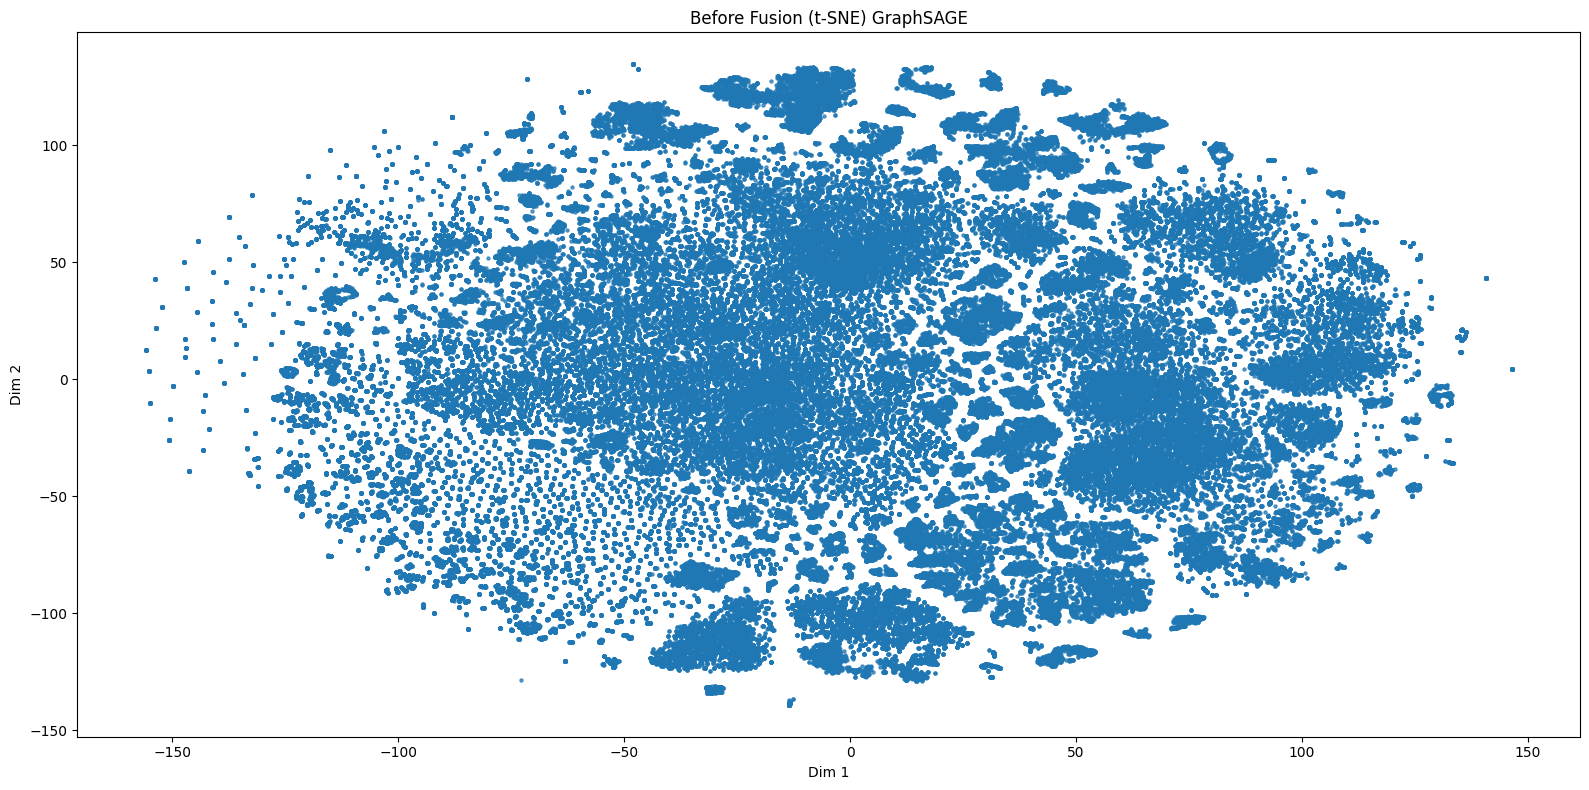

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap.umap_ import UMAP  # Correct import
import torch

import torch

# Function to generate t-SNE or UMAP projections and visualize them
def plot_embeddings(embeddings_dict, method="tsne", title_prefix="", save_path=None):
    """
    Visualize embeddings using t-SNE or UMAP.

    Parameters:
        embeddings_dict (dict): A dictionary where keys are model names and values are embeddings (numpy arrays).
        method (str): Dimensionality reduction method: 'tsne' or 'umap'.
        title_prefix (str): Prefix for plot titles.
        save_path (str, optional): Path to save the plot. If None, displays the plot.
    """
    # Initialize dimensionality reduction method
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "umap":
        reducer = UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne' or 'umap'")

    plt.figure(figsize=(16, 8))

    for i, (model_name, embeddings) in enumerate(embeddings_dict.items(), start=1):
        reduced_embeddings = reducer.fit_transform(embeddings)

        plt.subplot(1, len(embeddings_dict), i)
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, alpha=0.7)
        plt.title(f"{title_prefix} {model_name}")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

def generate_projections(models, attention_fusion, loader, device):
    """
    Generate and visualize t-SNE or UMAP projections for embeddings before and after fusion.

    Parameters:
        models (dict): Dictionary of trained GNN models.
        attention_fusion (AttentionFusion): Attention fusion module.
        loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to send computations (CPU or GPU).
    """
    attention_fusion.eval()
    embeddings_dict = {}
    fused_embeddings = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # Get embeddings from individual models
            model_embeddings = {name: model(data.x.to(device), data.edge_index.to(device)) for name, model in models.items()}
            for name, emb in model_embeddings.items():
                if name not in embeddings_dict:
                    embeddings_dict[name] = []
                embeddings_dict[name].append(emb)  # Keep embeddings on GPU

            # Get fused embeddings
            embeddings = [emb for emb in model_embeddings.values()]
            fused_emb = attention_fusion(embeddings)
            fused_embeddings.append(fused_emb)  # Keep on GPU

    # Move embeddings to CPU and convert to numpy for visualization
    for name in embeddings_dict:
        embeddings_dict[name] = np.concatenate([emb.cpu().numpy() for emb in embeddings_dict[name]], axis=0)
    fused_embeddings = np.concatenate([emb.cpu().numpy() for emb in fused_embeddings], axis=0)

    # Plot before fusion
    print("Generating projections for embeddings before fusion...")
    plot_embeddings(embeddings_dict, method="tsne", title_prefix="Before Fusion (t-SNE)")
    plot_embeddings(embeddings_dict, method="umap", title_prefix="Before Fusion (UMAP)")

    # Plot after fusion
    print("Generating projections for embeddings after fusion...")
    plot_embeddings({"Fused": fused_embeddings}, method="tsne", title_prefix="After Fusion (t-SNE)")
    plot_embeddings({"Fused": fused_embeddings}, method="umap", title_prefix="After Fusion (UMAP)")

# Example usage
# Assuming the models and attention_fusion module are trained, and test_loader and device are available
generate_projections(models, attention_fusion, test_loader, torch.device('cuda'))


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:0000:01


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the UPFD dataset (Politifact)
dataset_name = 'gossipcop'
feature = 'content'
root = './data/UPFD'

# Load train, validation, and test datasets
train_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='train')
val_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='val')
test_dataset = UPFD(root=root, name=dataset_name, feature=feature, split='test')

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define GNN Models (GCN, GAT, GraphSAGE)
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Attention Fusion Module
class AttentionFusion(torch.nn.Module):
    def __init__(self, num_views, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(num_views))
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, embeddings):
        attn_weights = self.softmax(self.attention_weights)
        attn_weights = attn_weights.view(1, len(embeddings), 1)
        emb_stack = torch.stack(embeddings, dim=1)
        fused_embedding = (emb_stack * attn_weights).sum(dim=1)
        return fused_embedding

# NT-Xent Loss
class NTXentLoss(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, embeddings):
        embeddings = F.normalize(embeddings, p=2, dim=1)
        similarity_matrix = torch.matmul(embeddings, embeddings.T)
        exp_similarity = torch.exp(similarity_matrix / self.temperature)
        
        mask = torch.eye(embeddings.size(0), device=embeddings.device).bool()
        exp_similarity = exp_similarity * ~mask

        positives = exp_similarity.diag()
        negatives = exp_similarity.sum(dim=1) - positives
        loss = -torch.log(positives / negatives).mean()
        return loss

# Initialize models
in_channels = train_dataset.num_features
hidden_channels = 64
out_channels = 32

models = {
    'GraphSAGE': GraphSAGEModel(in_channels, hidden_channels, out_channels).to(device),
}

attention_fusion = AttentionFusion(num_views=len(models), embedding_dim=out_channels).to(device)

optimizers = {model: torch.optim.Adam(models[model].parameters(), lr=0.005) for model in models}
optimizer_attn = torch.optim.Adam(attention_fusion.parameters(), lr=0.005)

# Training Loop
def train(models, attention_fusion, loaders, optimizers, optimizer_attn, epochs=20, temperature=0.5):
    train_loader, val_loader = loaders
    ntxent_loss = NTXentLoss(temperature=temperature).to(device)
    
    for epoch in range(1, epochs + 1):
        for data in train_loader:
            data = data.to(device)
            for optimizer in optimizers.values():
                optimizer.zero_grad()
            optimizer_attn.zero_grad()

            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)

            loss = ntxent_loss(fused_embedding)
            loss.backward()

            for optimizer in optimizers.values():
                optimizer.step()
            optimizer_attn.step()

        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

# Extract embeddings from test data
def get_embeddings(models, attention_fusion, loader):
    attention_fusion.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            embeddings = [model(data.x, data.edge_index) for model in models.values()]
            fused_embedding = attention_fusion(embeddings)
            all_embeddings.append(fused_embedding.mean(dim=0).cpu())
            all_labels.append(data.y.max().cpu())
    all_embeddings = torch.stack(all_embeddings)
    all_labels = torch.stack(all_labels).squeeze()
    return all_embeddings.numpy(), all_labels.numpy()

# Run the training and evaluation 10 times
results = []
for i in range(10):
    train(models, attention_fusion, (train_loader, val_loader), optimizers, optimizer_attn, epochs=10)

    test_embeddings, test_labels = get_embeddings(models, attention_fusion, test_loader)

    scaler = StandardScaler()
    test_embeddings_scaled = scaler.fit_transform(test_embeddings)

    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.9)
    svm_labels = svm.fit_predict(test_embeddings_scaled)
    svm_labels = np.where(svm_labels == -1, 1, 0)

    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, svm_labels, average='binary', pos_label=1)
    accuracy = accuracy_score(test_labels, svm_labels)

    results.append({
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })

avg_results = {key: np.mean([r[key] for r in results]) for key in results[0]}
std_results = {key: np.std([r[key] for r in results]) for key in results[0]}

for i, result in enumerate(results, 1):
    print(f"Run {i}: {result}")

print("\n--- Average Results with ± Standard Deviation ---")
for key in avg_results:
    print(f"{key}: {avg_results[key]:.4f} ± {std_results[key]:.4f}")


Extracting data/UPFD/gossipcop/raw/data.zip
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/10, Loss: nan
Epoch 2/10, Loss: nan
Epoch 3/10, Loss: nan
Epoch 4/10, Loss: nan
Epoch 5/10, Loss: nan
Epoch 6/10, Loss: nan
Epoch 7/10, Loss: nan
Epoch 8/10, Loss: nan
Epoch 9/10, Loss: nan
Epoch 10/10, Loss: nan


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
OneClassSVM does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values